In [1]:
import numpy as np
import os

In [2]:
os.environ["CUDA_VISIBLE_DEVICES"]="7"
os.environ['TF_DETERMINISTIC_OPS'] = '1'

In [3]:
import PIL
import tensorflow as tf
import random
import re
from tensorflow.python.framework.ops import disable_eager_execution
from tensorflow.python.framework.ops import enable_eager_execution
#disable_eager_execution()
enable_eager_execution()

In [4]:
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.applications.resnet50 import ResNet50
import tensorflow_datasets as tfds

In [5]:
from __future__ import print_function
import argparse
from tensorflow.keras.layers import Input
import scipy.misc

from configs import bcolors
from utils import *
import tensorflow_model_optimization as tfmot

In [6]:
def preprocess_image(features):
    """Preprocesses the given image.
       will convert the images from RGB to BGR, then will zero-center each color channel with respect to the ImageNet dataset, without scaling.
       mean = [103.939, 116.779, 123.68]
       std = None
  """
    image = features["image"]
    image = tf.image.resize(image,[224,224])
    image = tf.image.convert_image_dtype(image, dtype=tf.float32)
    image = tf.keras.applications.resnet.preprocess_input(image)
    features["image"] = image
    return features

# Load Data

In [10]:
BATCH_SIZE = 50
tfds_dataset2, tfds_info  = tfds.load(name='imagenet2012_subset', split='validation[-60%:]', with_info=True,
                                     data_dir='/local/rcs/wei/image_net/') # use the last 20% of images among 50000 validation images for testing
#tf.compat.v1.data.make_one_shot_iterator(tfds_dataset1).get_next()

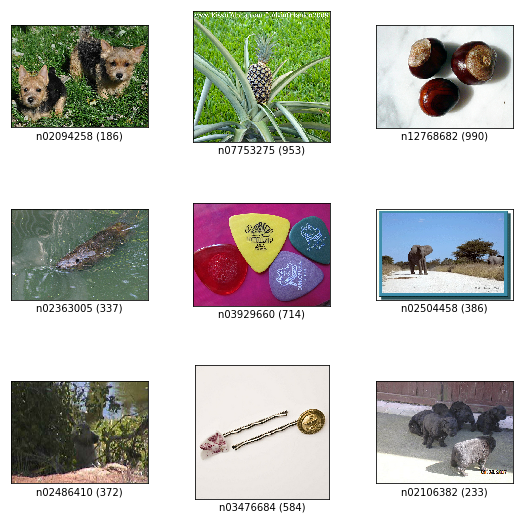

In [11]:
figs = tfds.show_examples(tfds_dataset2, tfds_info)

In [12]:
val_ds = tfds_dataset2.map(preprocess_image).batch(BATCH_SIZE).prefetch(1)

In [14]:
print(len(list(tfds_dataset2)))

30000


# Load Model

In [15]:
# input image dimensions
img_rows, img_cols = 224 ,224
input_shape = (img_rows, img_cols, 3)
model_ = ResNet50(input_shape=input_shape)

In [16]:
q_model = tfmot.quantization.keras.quantize_model(model_)

In [17]:
model = ResNet50(input_tensor = q_model.input)

In [18]:
model.load_weights("./original_model_40.h5")
q_model.load_weights("./int8_model_40.h5")

# Generate adverserial example

In [ ]:
grad_iterations = 20
step = 1
epsilon = 8

In [ ]:
def gen_one_image(image, label, loss_func):
    input_image = tf.convert_to_tensor(image)
    orig_img = tf.identity(input_image)
    orig_logist = tf.identity(model(image))
    orig_label =  np.argmax(orig_logist[0])
    
    A = 0
    
    for iters in range(0, grad_iterations):
        with tf.GradientTape() as g:
            g.watch(input_image)
            if loss_func == 'MSE':
                final_loss = tf.keras.losses.MSE(orig_logist[0] , q_model(input_image+A)[0])
            if loss_func == 'CCE':
                final_loss = tf.keras.losses.categorical_crossentropy(orig_logist[0] , q_model(input_image+A)[0])
            if loss_func == 'MEAN':
                final_loss = 1.0 - K.mean(q_model(input_image+A)[..., orig_label])

        grads = normalize(g.gradient(final_loss, input_image))
        A += tf.sign(grads) * step
        A = tf.clip_by_value(A, -epsilon, epsilon)
        test_image_deprocess = deprocess_image((input_image + A).numpy())
        test_image = np.expand_dims(tf.keras.applications.resnet.preprocess_input(test_image_deprocess), axis=0)
        pred1, pred2= model(test_image), q_model(test_image)
        label1, label2 = np.argmax(pred1[0]), np.argmax(pred2[0])
        if not label1 == label2:
            if label1 == orig_label and tf.keras.applications.resnet.decode_predictions(pred1.numpy(), top=5)[0][0][2] > 0.6:
                return (1, 0, A.numpy().astype(np.int8), pred1, pred2)
    
    indicator = 0 # 0: model right q_model wrong; 1: model right q_model wrong; 2: model wrong q_model right; 3: both wrong
    if label1 != orig_label and label2 != orig_label:
        indicator = 3
    elif label1 != orig_label and label2 == orig_label:
        indicator = 2
    elif label1 == orig_label and label2 == orig_label:
        indicator = 1
    else:
        indicator = 0
    return (0, indicator, A.numpy().astype(np.int8), pred1, pred2)
    

In [ ]:
def get_n_images(n, loss_func):
    d = {"both right": 0, "both wrong": 0, "model right q_model wrong": 0, "model wrong q_model right": 0}
    num = 0
    suc_cnt = 0
    for i, features in enumerate(val_ds):
        for j in range(50):
            if num < 28000:
                num += 1
                continue
            if os.path.exists("baseline_gen_" + loss_func + "/"+str(num)+"_filter.npy"):
                num += 1
                continue
            image = np.expand_dims(features['image'][j], axis=0)
            label = features['label'][j]
            pred1, pred2= model(image), q_model(image)
            label1, label2 = np.argmax(pred1[0]), np.argmax(pred2[0])
            if label1 != label2 or label1 != label:
                num += 1
                continue
            success, indicator, fil, pred1, pred2 = gen_one_image(image, label, loss_func)
            suc_cnt += success
            np.save("baseline_gen_" + loss_func + "/"+str(num)+"_filter.npy", fil)
            if indicator == 0:
                d["model right q_model wrong"] += 1
            elif indicator == 1:
                d["both right"] += 1
            elif indicator == 2:
                d["model wrong q_model right"] += 1
            else:
                d["both wrong"] += 1
            num += 1
            if num == n:
                return suc_cnt, d
        print((i+1)*50)
    return suc_cnt, d

## 1. A = argmax c*L( q_model(image + A) , sudo_y) -  L( orig_model(image + A) , y) 

In [ ]:
suc_cnt_mse, d_mse = get_n_images(31000, "MSE")

In [ ]:
print("loss function: MSE")
print("success: " + str(suc_cnt_mse/sum(d_mse.values())*100) + "%")
print(d_mse)

## 2. A = argmax orig_model(image + A)[y] - c*q_model(image + A)[y]

In [ ]:
suc_cnt_mean, d_mean = get_n_images(31000, "MEAN")

In [34]:
print("loss function: MEAN")
print("success: " + str(suc_cnt_mean) + "/2000")
print(d_mean)

loss function: MEAN
total: 100
{'both right': 0, 'both wrong': 59, 'model right q_model wrong': 41, 'model wrong q_model right': 0}


# 3. Cross Entropy Loss

In [ ]:
suc_cnt_cce, d_cce = get_n_images(31000, "CCE")

In [ ]:
print("loss function: CCE")
print("success rate: " + str(suc_cnt_cce/sum(d_cce.values())*100) + "%")
print(d_cce)

# Evaluation

In [34]:
def eval1(n, loss_func):
    num = 0
    suc_cnt = 0
    good_image_cnt = 0
    top5_misclassification_cnt = 0
    for i, features in enumerate(val_ds):
        for j in range(50):
            try:
                fil = np.load("baseline_gen_" + loss_func + "/"+str(num)+"_filter.npy")
            except:
                num += 1
                continue
            image = np.expand_dims(features['image'][j], axis=0)
            label = features['label'][j]
            pred1, pred2= model(image), q_model(image)
            label1, label2 = np.argmax(pred1[0]), np.argmax(pred2[0])
            if label1 != label2 or label1 != label:
                os.remove("baseline_gen_" + loss_func + "/"+str(num)+"_filter.npy")
                num += 1
                continue
            good_image_cnt += 1
            gen_image = fil + image
            pred1, pred2 = model(gen_image), q_model(gen_image)
            label1, label2 = np.argmax(pred1[0]), np.argmax(pred2[0])
            if pred1[0][label1] >= 0.6 and label == label1 and label != label2:
                suc_cnt += 1
            q_top5 = np.argpartition(pred2[0], -5)[-5:]
            if label not in q_top5:
                top5_misclassification_cnt += 1
            
            num += 1
            if num == n:
                return good_image_cnt, suc_cnt, top5_misclassification_cnt
        print(num)
    return good_image_cnt, suc_cnt, top5_misclassification_cnt

In [35]:
good_image_cnt, suc_cnt, top5_misclassification_cnt = eval1(31000, "MSE")

50
100
150
200
250
300
350
400
750
800
850
900
950
1000
1050
1100
1150
1200
1250
1300
1350
1400
1450
1500
1550
1600
1650
1700
1750
1800
1850
1900
1950
2000
2050
2100
2150
2200
2250
2300
2350
2400
2450
2500
2550
2600
2650
2700
2750
2800
2850
2900
2950
3000
3050
3100
3150
3200
3250
3300
3350
3400
3450
3500
3550
3600
3650
3700
3750
3800
3850
3900
3950
4000
4050
4100
4150
4200
4250
4300
4350
4400
4450
4500
4550
4600
4650
4700
4750
4800
4850
4900
4950
5000
5050
5100
5150
5200
5250
5300
5350
5400
5450
5500
5550
5600
5650
5700
5750
5800
5850
5900
5950
6000
6050
6100
6150
6200
6250
6300
6350
6400
6450
6500
6550
6600
6650
6700
6750
6800
6850
6900
6950
7000
7050
7100
7150
7200
7250
7300
7350
7400
7450
7500
7550
7600
7650
7700
7750
7800
7850
7900
7950
8000
8050
8100
8150
8200
8250
8300
8350
8400
8450
8500
8550
8600
8650
8700
8750
8800
8850
8900
8950
9000
9050
9100
9150
9200
9250
9300
9350
9400
9450
9500
9550
9600
9650
9700
9750
9800
9850
9900
9950
10000
10050
10100
10150
10200
10250
10300
10350
1

In [36]:
print("total number of good images: " + str(good_image_cnt))
print("success rate: " + str(suc_cnt/good_image_cnt*100) + "%")
print("top-5 misclassification rate: " + str(top5_misclassification_cnt/good_image_cnt*100) + "%")

total number of good images: 19381
success rate: 36.66477477942315%
top-5 misclassification rate: 43.94510087198803%


In [31]:
len([name for name in os.listdir('./baseline_gen_MSE') if name[-3:] == "npy"])

18494

In [37]:
good_image_cnt, suc_cnt, top5_misclassification_cnt = eval1(31000, "MEAN")

50
100
150
200
250
300
350
400
450
500
550
600
650
700
750
800
850
900
950
1000
1050
1100
1150
1200
1250
1300
1350
1400
1450
1500
1550
1600
1650
1700
1750
1800
1850
1900
1950
2000
2050
2100
2150
2200
2250
2300
2350
2400
2450
2500
2550
2600
2650
2700
2750
2800
2850
2900
2950
3000
3050
3100
3150
3200
3250
3300
3350
3400
3450
3500
3550
3600
3650
3700
3750
3800
3850
3900
3950
4000
4050
4100
4150
4200
4250
4300
4350
4400
4450
4500
4550
4600
4650
4700
4750
4800
4850
4900
4950
5000
5050
5100
5150
5200
5250
5300
5350
5400
5450
5500
5550
5600
5650
5700
5750
5800
5850
5900
5950
6000
6050
6100
6150
6200
6250
6300
6350
6400
6450
6500
6550
6600
6650
6700
6750
6800
6850
6900
6950
7000
7050
7100
7150
7200
7250
7300
7350
7400
7450
7500
7550
7600
7650
7700
7750
7800
7850
7900
7950
8000
8050
8100
8150
8200
8250
8300
8350
8400
8450
8500
8550
8600
8650
8700
8750
8800
8850
8900
8950
9000
9050
9100
9150
9200
9250
9300
9350
9400
9450
9500
9550
9600
9650
9700
9750
9800
9850
9900
9950
10000
10050
10100
10150
1

In [38]:
print("total number of good images: " + str(good_image_cnt))
print("success rate: " + str(suc_cnt/good_image_cnt*100) + "%")
print("top-5 misclassification rate: " + str(top5_misclassification_cnt/good_image_cnt*100) + "%")

total number of good images: 19300
success rate: 38.94818652849741%
top-5 misclassification rate: 55.020725388601036%


In [39]:
good_image_cnt, suc_cnt, top5_misclassification_cnt = eval1(31000, "CCE")

50
100
150
200
250
300
350
400
450
500
550
600
650
700
750
800
850
900
950
1000
1050
1100
1150
1200
1250
1300
1350
1400
1450
1500
1550
1600
1650
1700
1750
1800
1850
1900
1950
2000
2050
2100
2150
2200
2250
2300
2350
2400
2450
2500
2550
2600
2650
2700
2750
2800
2850
2900
2950
3000
3050
3100
3150
3200
3250
3300
3350
3400
3450
3500
3550
3600
3650
3700
3750
3800
3850
3900
3950
4000
4050
4100
4150
4200
4250
4300
4350
4400
4450
4500
4550
4600
4650
4700
4750
4800
4850
4900
4950
5000
5050
5100
5150
5200
5250
5300
5350
5400
5450
5500
5550
5600
5650
5700
5750
5800
5850
5900
5950
6000
6050
6100
6150
6200
6250
6300
6350
6400
6450
6500
6550
6600
6650
6700
6750
6800
6850
6900
6950
7000
7050
7100
7150
7200
7250
7300
7350
7400
7450
7500
7550
7600
7650
7700
7750
7800
7850
7900
7950
8000
8050
8100
8150
8200
8250
8300
8350
8400
8450
8500
8550
8600
8650
8700
8750
8800
8850
8900
8950
9000
9050
9100
9150
9200
9250
9300
9350
9400
9450
9500
9550
9600
9650
9700
9750
9800
9850
9900
9950
10000
10050
10100
10150
1

In [40]:
print("total number of good images: " + str(good_image_cnt))
print("success rate: " + str(suc_cnt/good_image_cnt*100) + "%")
print("top-5 misclassification rate: " + str(top5_misclassification_cnt/good_image_cnt*100) + "%")

total number of good images: 19371
success rate: 38.77445666202055%
top-5 misclassification rate: 52.35145320324196%
